Simple Logistic Regression with TFIDF ..........

Predict if the Job Descriptions are Real or Fraud

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedKFold

C:\Users\Zenia\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Zenia\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Zenia\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
df = pd.read_csv(r"C:\Users\Zenia\Downloads\fake_job_postings.csv/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Feature Engineering

Create features from text columns : length of text and TFIDF

In [4]:
cols = ["title", "company_profile", "description", "requirements", "benefits"]

for c in cols:
    df[c] = df[c].fillna("")

In [11]:
def extract_features(df):    
    for c in cols:
        df[c+"_len"] = df[c].apply(lambda x : len(str(x)))
        df[c+"_wc"] = df[c].apply(lambda x : len(str(x.split())))

    
extract_features(df)       

# Create TF IDF Features

In [12]:
df["combined_text"] = df["company_profile"] + " " + df["description"] + " " + df["requirements"] + df["benefits"]

In [13]:
n_features = {
    "title" : 100,
    "combined_text" : 500
}

for c, n in n_features.items():
    tfidf = TfidfVectorizer(max_features=n, norm='l2', stop_words = 'english')
    tfidf.fit(df[c])
    tfidf_train = np.array(tfidf.transform(df[c]).toarray(), dtype=np.float16)

    for i in range(n_features[c]):
        df[c + '_tfidf_' + str(i)] = tfidf_train[:, i]

One Hot Encoding for Categorical Columns

In [14]:
cat_cols = ["employment_type", "required_experience", "required_education", "industry", "function"]
for c in cat_cols:
    encoded = pd.get_dummies(df[c])
    df = pd.concat([df, encoded], axis=1)

Prepare Dataset : Drop unnecessary columns

In [15]:
drop_cols = ['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'combined_text']
drop_cols += cat_cols
df = df.drop(drop_cols, axis = 1)
df.head()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,title_len,title_wc,company_profile_len,company_profile_wc,description_len,...,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
0,1,0,1,0,0,16,23,885,1309,905,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,41,60,1286,1745,2077,...,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,39,52,879,1302,355,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,0,0,33,49,614,868,2600,...,0,0,0,0,1,0,0,0,0,0
4,5,0,1,1,0,19,29,1628,2250,1520,...,0,0,0,0,0,0,0,0,0,0


# Logistic Model

In [16]:
df.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in df.columns]
idd, target = "job_id", "fraudulent"
features = [f for f in df.columns if f not in [idd, target]]

X = df[features]
y = df[target]

kf = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)
auc_buf = []   
cnt = 0
for train_index, valid_index in kf.split(X):
    print('Fold {}'.format(cnt + 1))

    train_x,train_y = X.loc[train_index], y.loc[train_index]
    test_x, test_y = X.loc[valid_index], y.loc[valid_index]
    
    clf = LogisticRegression(max_iter = 5000).fit(train_x, train_y)
    preds = clf.predict(test_x)
    
    auc = roc_auc_score(test_y, preds)
    print('{} AUC: {}'.format(cnt, auc))
    auc_buf.append(auc)

    cnt += 1

auc_mean = np.mean(auc_buf)
auc_std = np.std(auc_buf)
print('AUC = {:.6f} +/- {:.6f}'.format(auc_mean, auc_std))

Fold 1


C:\Users\Zenia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0 AUC: 0.7723684210526316
Fold 2


C:\Users\Zenia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1 AUC: 0.7574743051754544
Fold 3


C:\Users\Zenia\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2 AUC: 0.7358357480555131
AUC = 0.755226 +/- 0.014999


# An easy starter kernel 

In [18]:
"""Importing libraries"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from tqdm import tqdm
import time
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn import preprocessing, model_selection, pipeline
from sklearn.metrics import f1_score, roc_auc_score

C:\Users\Zenia\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Zenia\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


ModuleNotFoundError: No module named 'xgboost'

In [94]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [19]:
import sys
!{sys.executable} -m pip install xgboost

In [20]:
import xgboost as xgb

In [21]:
df = pd.read_csv(r"C:\Users\Zenia\Downloads\fake_job_postings.csv/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [23]:
"Extracting Text Features"

new_df = df[["title", "company_profile", "description", "requirements", "benefits", "fraudulent"]]
new_df = new_df.fillna("No Information")

new_df.head()

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,No Information,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,No Information,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [24]:
new_df.shape

(17880, 6)

17880

In [25]:
new_df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [27]:
17014/(17014+866)*100

95.1565995525727

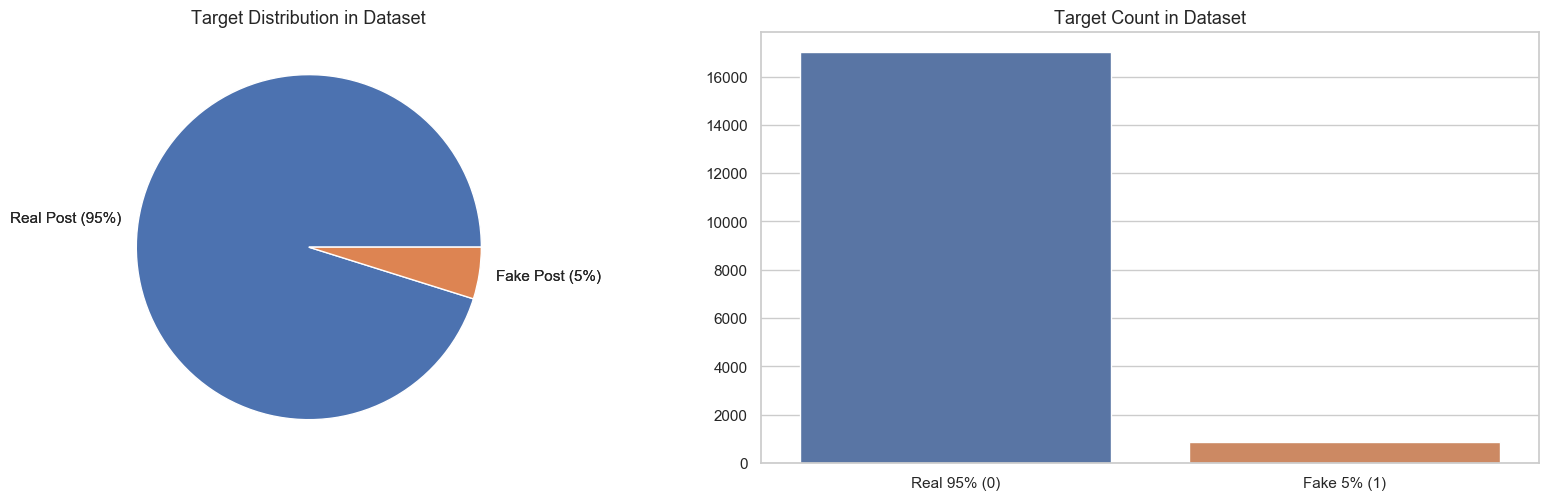

In [57]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(17, 5), dpi=100) #(sharex='col', sharey='row',)
plt.tight_layout()


"""
This works too !!!

labels = [new_df.shape[0], new_df.shape[1]]
sizes = [95, 5]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()

ax[0].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


""" 


temp = new_df["fraudulent"].value_counts()
temp.plot(kind='pie', ax=ax[0], labels=['Real Post (95%)', 'Fake Post (5%)'])


temp.plot(kind='pie', ax=ax[0], labels=['Real Post (95%)', 'Fake Post (5%)'])




#sns.barplot(temp.index, temp, ax=axes[1])




ax[1]= sns.barplot(x=temp.index, y=temp)
ax[1].set_xticklabels(labels= ["Real 95% (0)", "Fake 5% (1)"]) #Set the tick labels for x ; (rotation=45)

ax[0].set_ylabel(' ')
ax[1].set_ylabel(' ')

ax[0].set_title('Target Distribution in Dataset', fontsize=13)
ax[1].set_title('Target Count in Dataset', fontsize=13)



plt.show()

In [ ]:
"""

Axisgrid Objects

>>> g.despine(left=True) Remove left spine
>>> g.set_ylabels("Survived") Set the labels of the y-axis
>>> g.set_xticklabels(rotation=45) Set the tick labels for x
>>> g.set_axis_labels("Survived", Set the axis labels
 "Sex")
>>> h.set(xlim=(0,5), Set the limit and ticks of the
 ylim=(0,5), x-and y-axis
 xticks=[0,2.5,5],
 yticks=[0,2.5,5])


"""

"""


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


"""

Hmm!! Class distributions are 95% for 0 (Real Post) and 5% for 1 (Fake Post). Target distribution is highly imbalanced. Accuracy metric is not useful here it will mislead the result. So, we've to look into Precision, Recall, F1 Score for model evalution.

Number of characters
Let's compare the number of character in the fake post and real post and try to distinguish pattern in the fake and real post based on number of charater used in the post.

1. Company profile

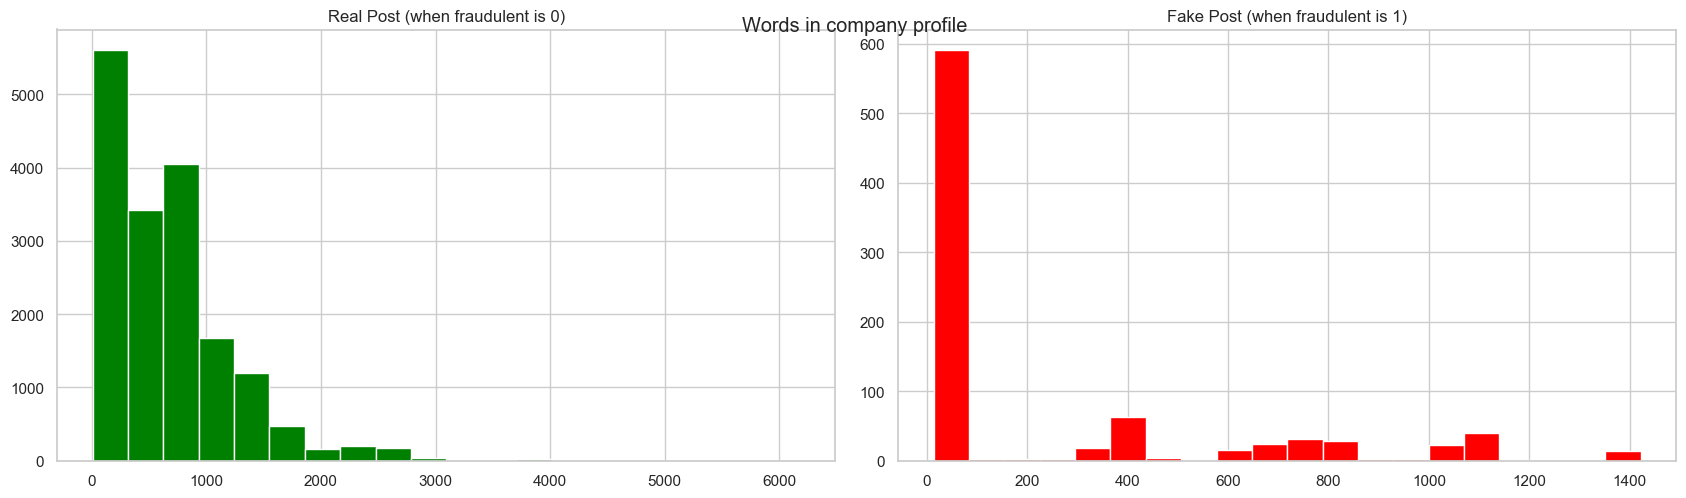

In [86]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(17, 5), dpi=100) #(sharex='col', sharey='row',)
plt.tight_layout()

real_company_profile = new_df[new_df["fraudulent"]==0]["company_profile"].str.len()
fake_company_profile = new_df[new_df["fraudulent"]==1]["company_profile"].str.len()


"""

N_points = 100000
n_bins = 20

# Generate a normal distribution, center at x=0 and y=5
x = np.random.randn(N_points)
y = .4 * x + np.random.randn(100000) + 5

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs[0].hist(x, bins=n_bins)
axs[1].hist(y, bins=n_bins)


""" 

ax[0].hist(x=real_company_profile, color = "green", bins = 20)
ax[1].hist(x=fake_company_profile, color = "red", bins = 20)


ax[0].set_title('Real Post (when fraudulent is 0)')
ax[1].set_title('Fake Post (when fraudulent is 1)')

fig.suptitle('Words in company profile')

plt.show()

We can see that fake post has less characters in the company profile while real post has more charaters.

2. Company profile

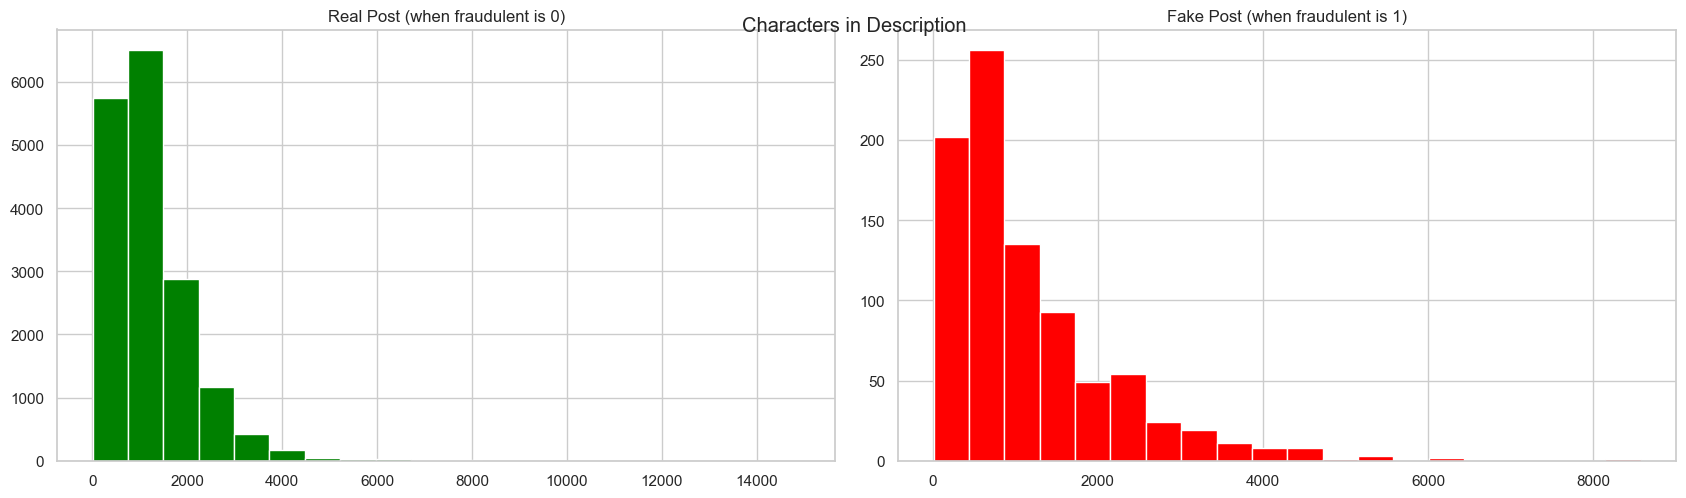

In [84]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(17, 5), dpi=100) #(sharex='col', sharey='row',)
plt.tight_layout()

real_company_profile = new_df[new_df["fraudulent"]==0]["description"].str.len()
fake_company_profile = new_df[new_df["fraudulent"]==1]["description"].str.len()
 

ax[0].hist(x=real_company_profile, color = "green", bins = 20)
ax[1].hist(x=fake_company_profile, color = "red", bins = 20)


ax[0].set_title('Real Post (when fraudulent is 0)')
ax[1].set_title('Fake Post (when fraudulent is 1)')

fig.suptitle('Characters in Description')


plt.show()


So we see The distribution of charaters in description of the fake and real post are similar but some fake post reach to 6000 to 6500 characters.

3. Requirements

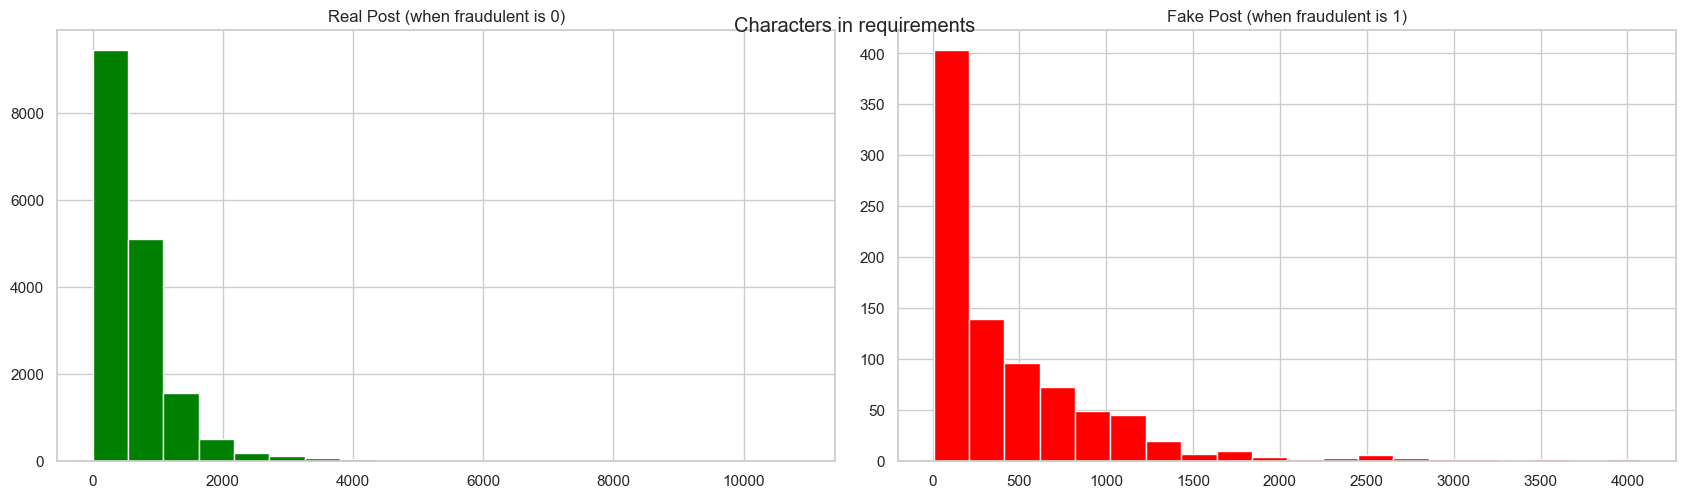

In [83]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(17, 5), dpi=100) #(sharex='col', sharey='row',)
plt.tight_layout()

real_company_profile = new_df[new_df["fraudulent"]==0]["requirements"].str.len()
fake_company_profile = new_df[new_df["fraudulent"]==1]["requirements"].str.len()
 

ax[0].hist(x=real_company_profile, color = "green", bins = 20)
ax[1].hist(x=fake_company_profile, color = "red", bins = 20)


ax[0].set_title('Real Post (when fraudulent is 0)')
ax[1].set_title('Fake Post (when fraudulent is 1)')

fig.suptitle('Characters in requirements')

plt.show()


So we see, The distribution of charaters in requirements of the fake and real post are almost similar.

4. Benefits

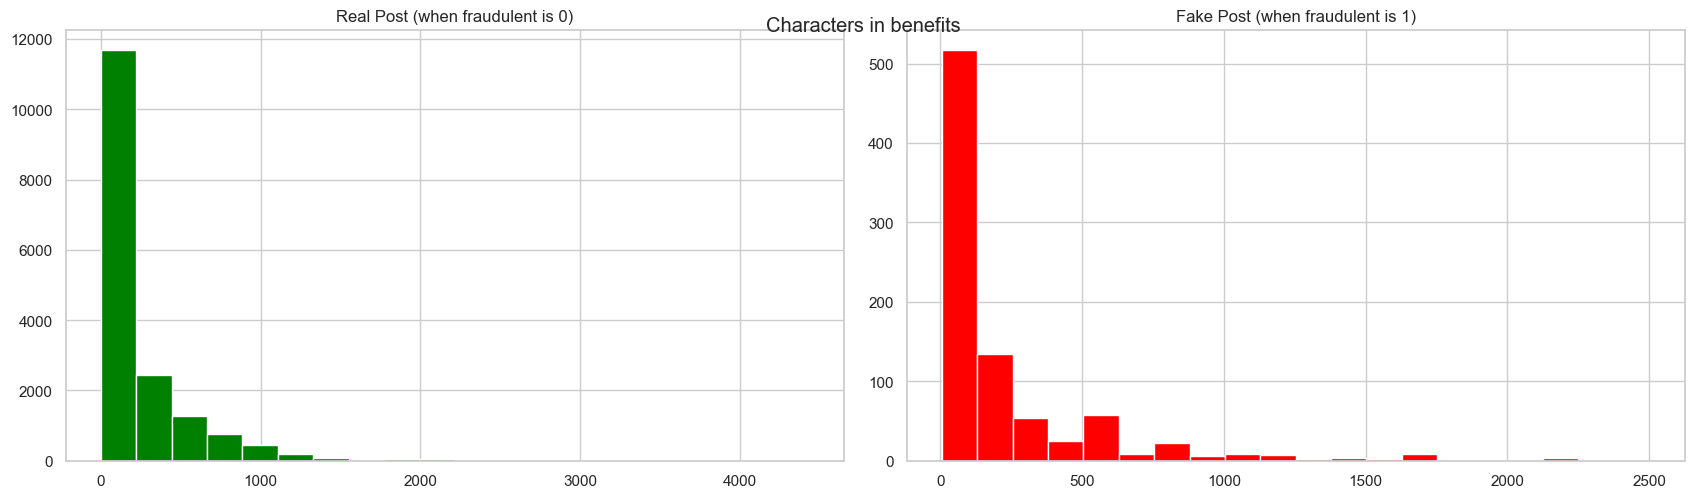

In [82]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(17, 5), dpi=100) #(sharex='col', sharey='row',)
plt.tight_layout()

real_company_profile = new_df[new_df["fraudulent"]==0]["benefits"].str.len()
fake_company_profile = new_df[new_df["fraudulent"]==1]["benefits"].str.len()
 

ax[0].hist(x=real_company_profile, color = "green", bins = 20)
ax[1].hist(x=fake_company_profile, color = "red", bins = 20)


ax[0].set_title('Real Post (when fraudulent is 0)')
ax[1].set_title('Fake Post (when fraudulent is 1)')

fig.suptitle('Characters in benefits')

plt.show()


so we see, The distribution of words in benefits of the fake and real post are also similar.

Data Preprocessing 

In [88]:
"""Concate the text data for preprocessing and modeling"""
text = new_df[new_df.columns[0:-1]].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)
target = df['fraudulent']

print(len(text))
print(len(target))

17880
17880


In [89]:
print(text)

0        Marketing Intern,We're Food52, and we've creat...
1        Customer Service - Cloud Video Production,90 S...
2        Commissioning Machinery Assistant (CMA),Valor ...
3        Account Executive - Washington DC,Our passion ...
4        Bill Review Manager,SpotSource Solutions LLC i...
                               ...                        
17875    Account Director - Distribution ,Vend is looki...
17876    Payroll Accountant,WebLinc is the e-commerce p...
17877    Project Cost Control Staff Engineer - Cost Con...
17878    Graphic Designer,No Information,Nemsia Studios...
17879    Web Application Developers,Vend is looking for...
Length: 17880, dtype: object


Ngrams Analysis

Most common unigrams exist in both classes are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about target.

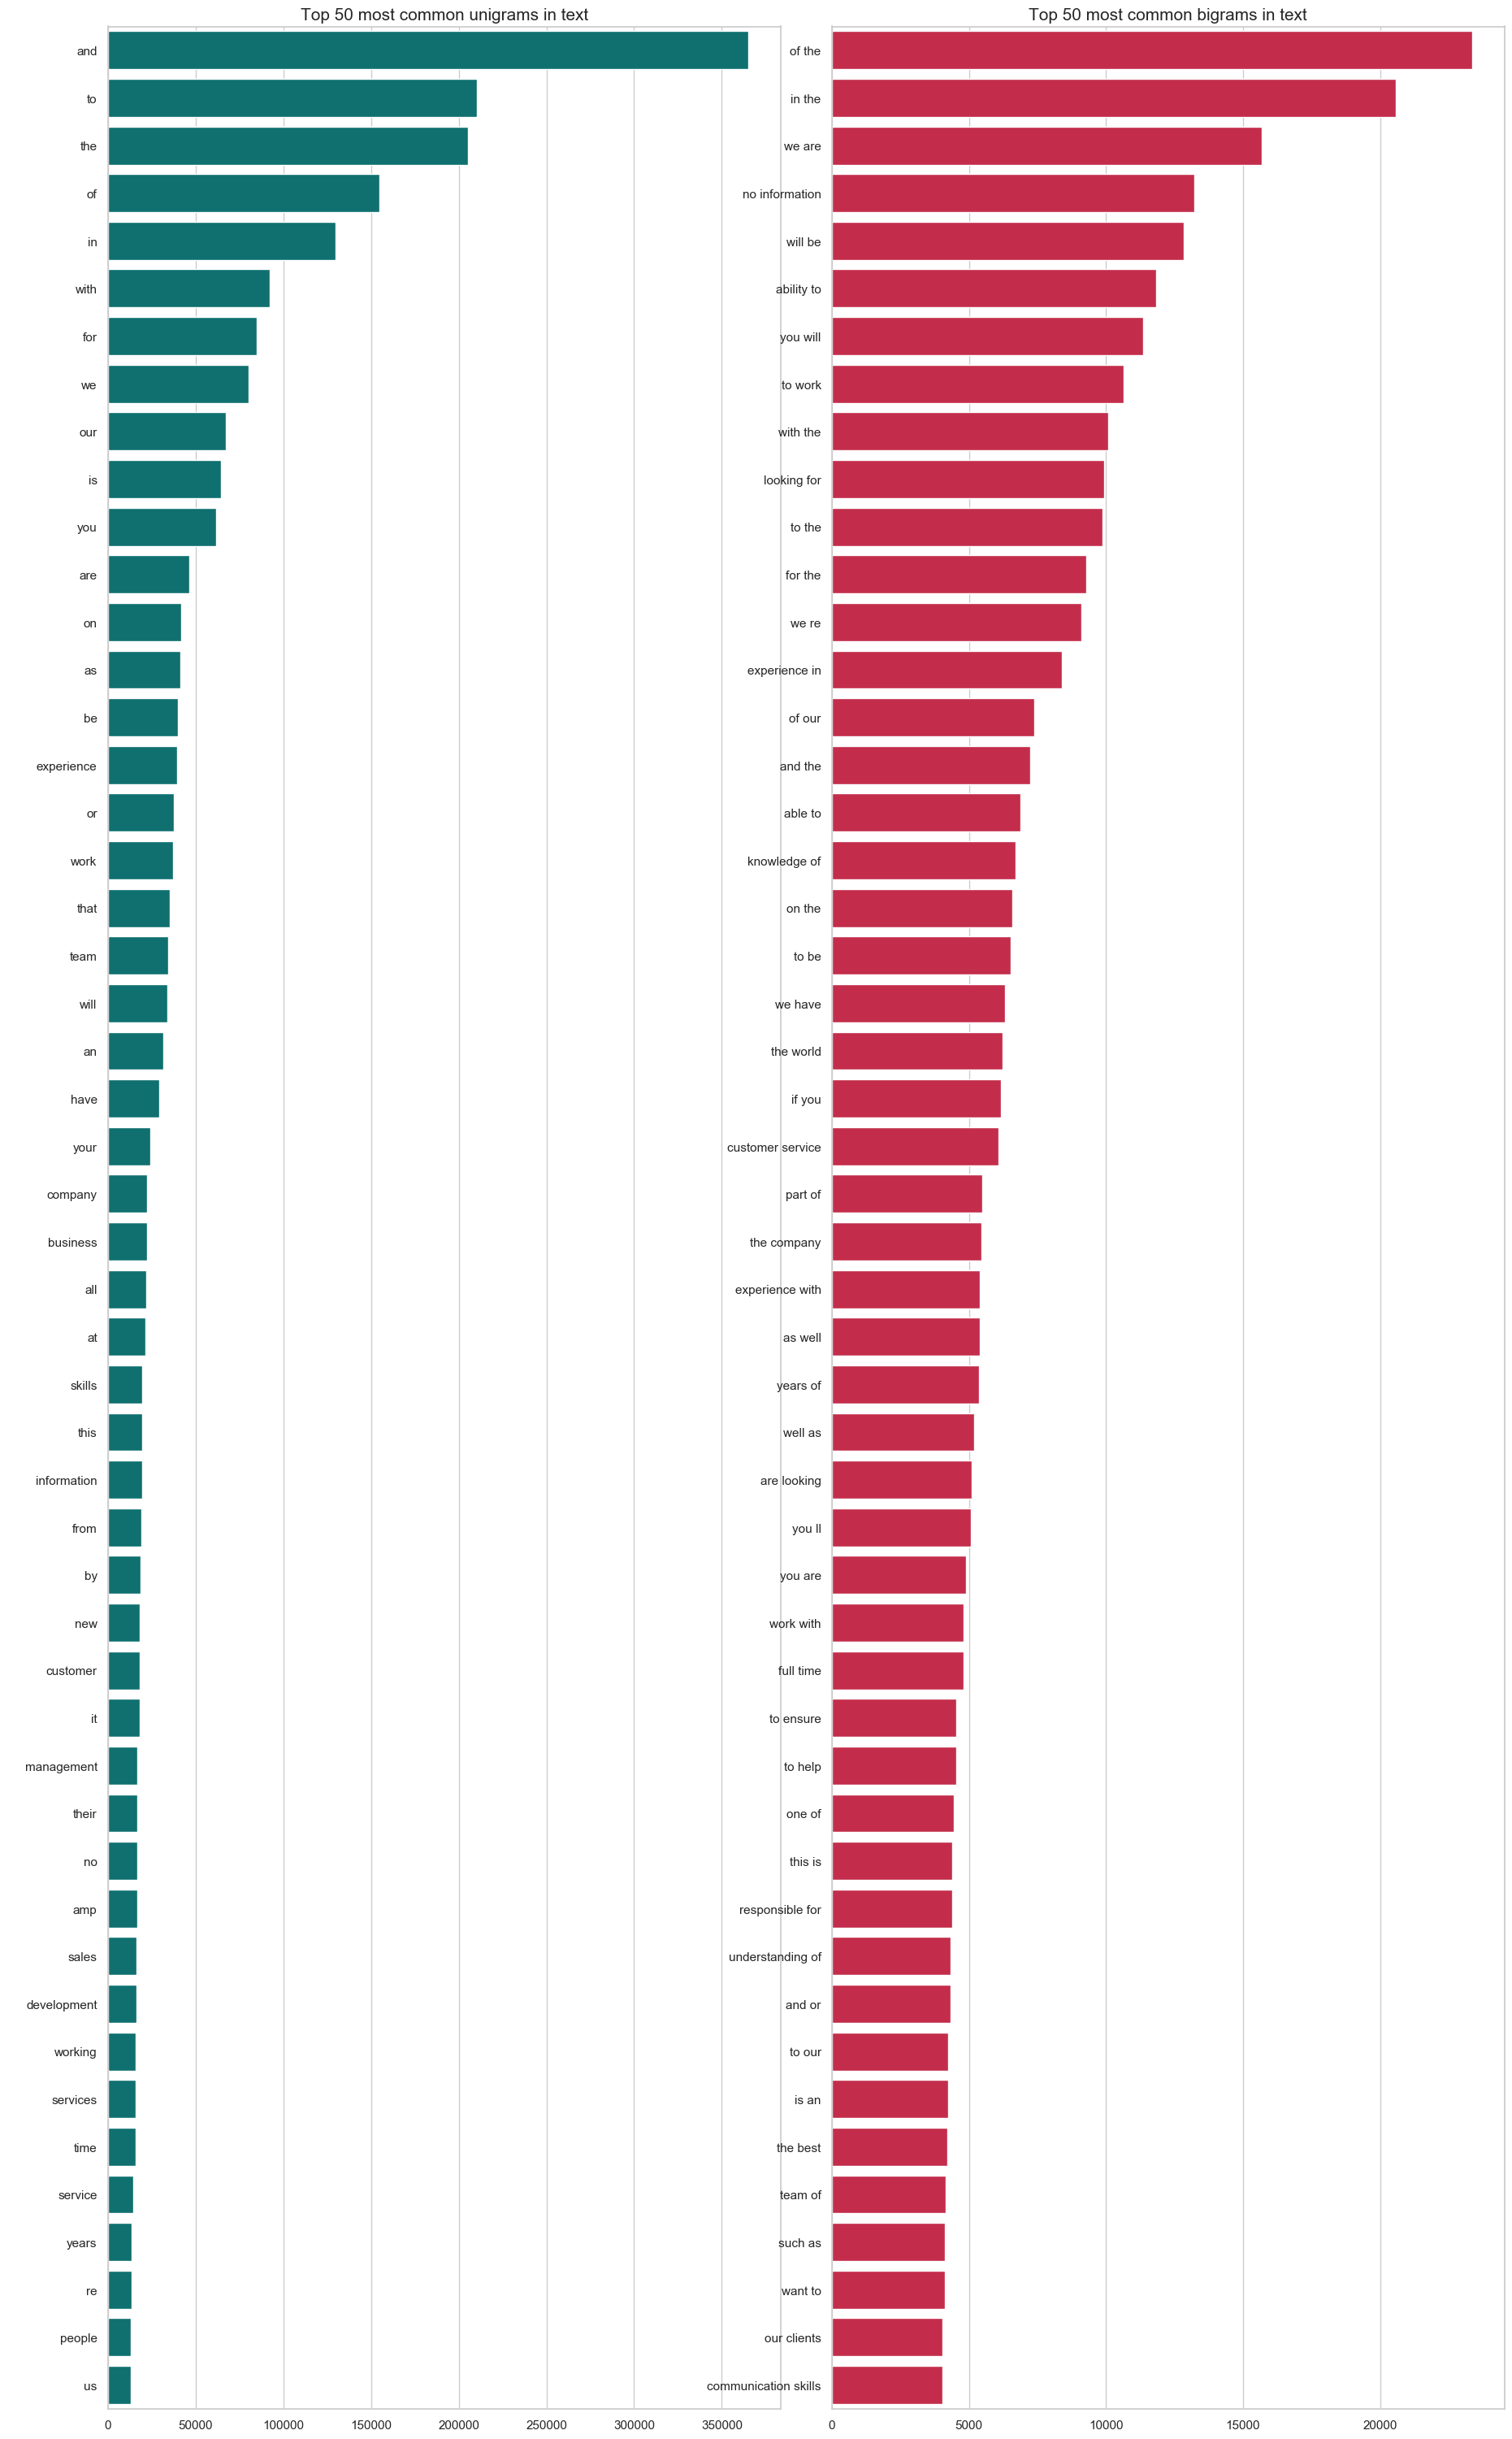

In [90]:
def get_top_tweet_unigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

fig, axes = plt.subplots(ncols=2, figsize=(18, 30), dpi=100)
plt.tight_layout()

top_unigrams=get_top_tweet_unigrams(text)[:50]
x,y=map(list,zip(*top_unigrams))
sns.barplot(x=y,y=x, ax=axes[0], color='teal')


top_bigrams=get_top_tweet_bigrams(text)[:50]
x,y=map(list,zip(*top_bigrams))
sns.barplot(x=y,y=x, ax=axes[1], color='crimson')


axes[0].set_ylabel(' ')
axes[1].set_ylabel(' ')

axes[0].set_title('Top 50 most common unigrams in text', fontsize=15)
axes[1].set_title('Top 50 most common bigrams in text', fontsize=15)

plt.show()

Text cleaning

In [91]:
"""

import re
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("<!--?.*?-->","",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text
 
df_idf['text'] = df_idf['title'] + df_idf['body']
df_idf['text'] = df_idf['text'].apply(lambda x:pre_process(x))
 
#show the second 'text' just for fun
df_idf['text'][2]
 


"""



%%time
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
text = text.apply(lambda x: clean_text(x))
text.head(3)

Wall time: 10 s


Tokenizer

In [92]:
%%time
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# appling tokenizer5
text = text.apply(lambda x: tokenizer.tokenize(x))
text.head(3)

Wall time: 3.8 s


In [95]:
%%time
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words


text = text.apply(lambda x : remove_stopwords(x))

Wall time: 44min 35s


Below is an example of computing the TF-IDF scores for all the words in the corpus.

In [96]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

documentA = 'the man went out for a walk'
documentB = 'the children sat around the fire'

vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([documentA, documentB])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

"""

#create a vocabulary of words, 
#ignore words that appear in 85% of documents, 
#eliminate stop words
cv=CountVectorizer(max_df=0.85,stop_words=stopwords,max_features=10000)
word_count_vector=cv.fit_transform(docs)


While cv.fit(...) would only create the vocabulary, cv.fit_transform(...) creates the vocabulary and 
returns a term-document matrix which is what we want. With this, each column in the matrix represents 
a word in the vocabulary while each row represents the document in our dataset where the values in this case 
are the word counts. Note that with this representation, counts of some words could be 0 
if the word did not appear in the corresponding document.

Notice that in the code above, we are passing two parameters to CountVectorizer, max_df and stop_words. 
The first is just to say ignore all words that have appeared in 85% of the documents, since those may be unimportant. 
The later, is a custom stop words list. You can also use stop words that are native to sklearn by setting stop_words='english'.


The resulting shape of word_count_vector would be (20000,124901) since we have 20,000 documents in our dataset (the rows) and 
the vocabulary size is 124,901. It’s really easy to limit this by setting max_features=vocab_size when instantiating CountVectorizer. 
For this tutorial let’s limit our vocabulary size to 10,000. 
you can check the first 10 words from the vocabulary using this command:

 
list(cv.vocabulary_.keys())[:10]

"""

In [97]:
%%time
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

text = text.apply(lambda x : combine_text(x))

Wall time: 821 ms


Baseline Model

In [98]:
# Stratified k-fold cross-validation with an imbalanced dataset
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
auc_buf = []   
cnt = 0
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(text, target):
    print('Fold {}'.format(cnt + 1))
    train_X, test_X = text[train_ix], text[test_ix]
    train_y, test_y = target[train_ix], target[test_ix]

    # Appling Count Vectorizer
    count_vectorizer = CountVectorizer()
    train_X_vec = count_vectorizer.fit_transform(train_X)
    test_X_vec = count_vectorizer.transform(test_X)
    
    lr = LogisticRegression(C=0.1, solver='lbfgs', max_iter = 1000)
    lr.fit(train_X_vec, train_y)
    preds = lr.predict(test_X_vec)
    
    auc = roc_auc_score(test_y, preds)
    print('{} AUC: {}'.format(cnt, auc))
    auc_buf.append(auc)

    cnt += 1

print('AUC mean score = {:.6f}'.format(np.mean(auc_buf)))
print('AUC std score = {:.6f}'.format(np.std(auc_buf)))

Fold 1
0 AUC: 0.8608935320761599
Fold 2
1 AUC: 0.8375625722968004
Fold 3
2 AUC: 0.8086608381927541
Fold 4
3 AUC: 0.8426082732169338
Fold 5
4 AUC: 0.8687664175782353
AUC mean score = 0.843698
AUC std score = 0.020931


It seem simple Logistic Regression model perform well. AUC of 0.84 demonstrating the good fitting of chosen model. 